# exp061
相対補正をgtによる異常値除去の前に実施 ましまし

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 

In [2]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

rel_rate = 0.5 # 相対予測の補正率

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

# 相対予測での補正を行うcollection
rel_target = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [3]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [4]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [5]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [34]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [8]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [9]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [10]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [11]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# 相対移動距離をもとにした外れ値除去

In [12]:
train, test, sub, gt = get_data()

In [13]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [14]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train.to_csv(OUTPUT + '/train_ro.csv', index=False)

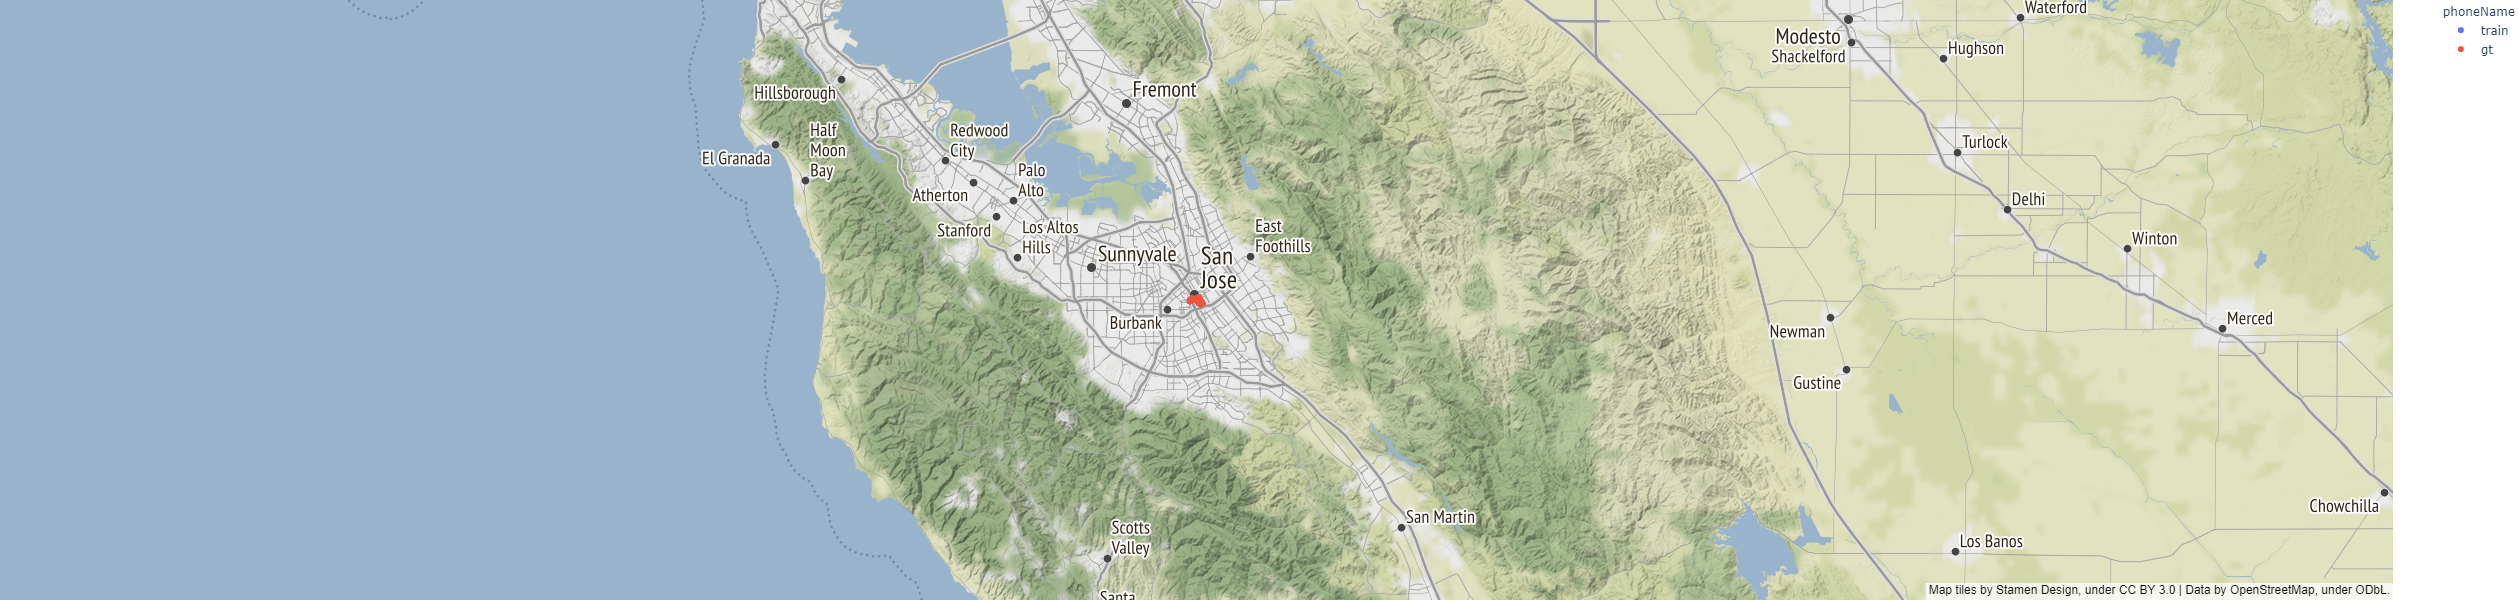

In [35]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# ground_truthを基準にした外れ値除去

In [36]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        collection = target_df.at[idx, 'collectionName']
        
        if collection in ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']:
            th = 3
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

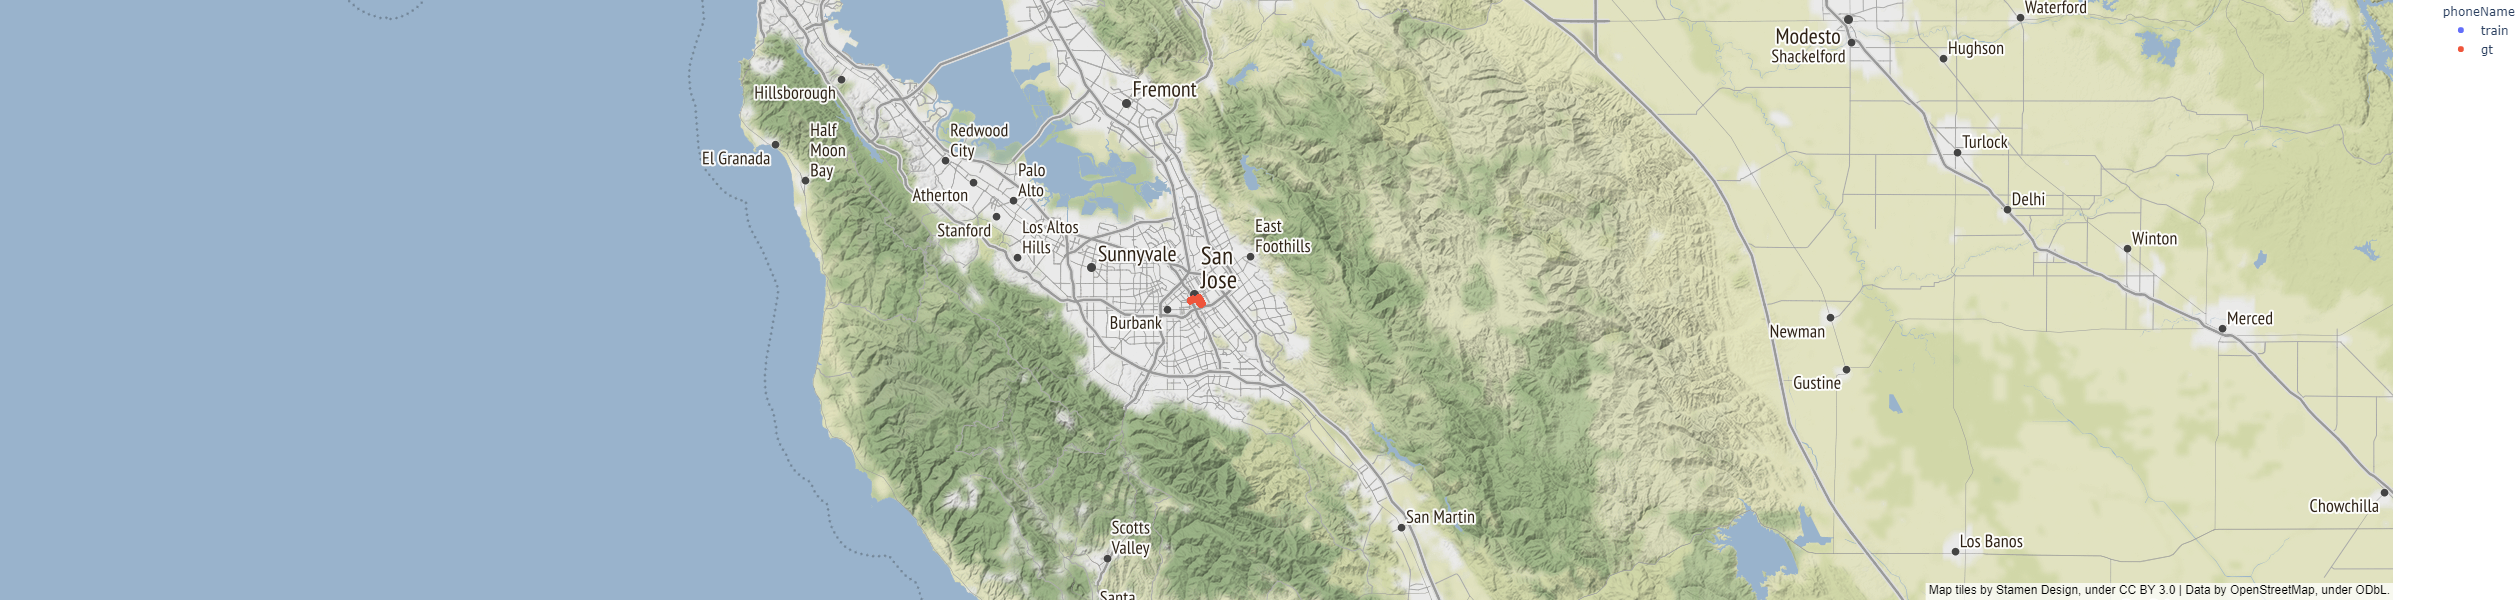

In [37]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

In [38]:
rog_df = interpolate_remove_point(rog_df)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]
train.to_csv(OUTPUT + '/train_ro_rel_rog.csv', index=False)

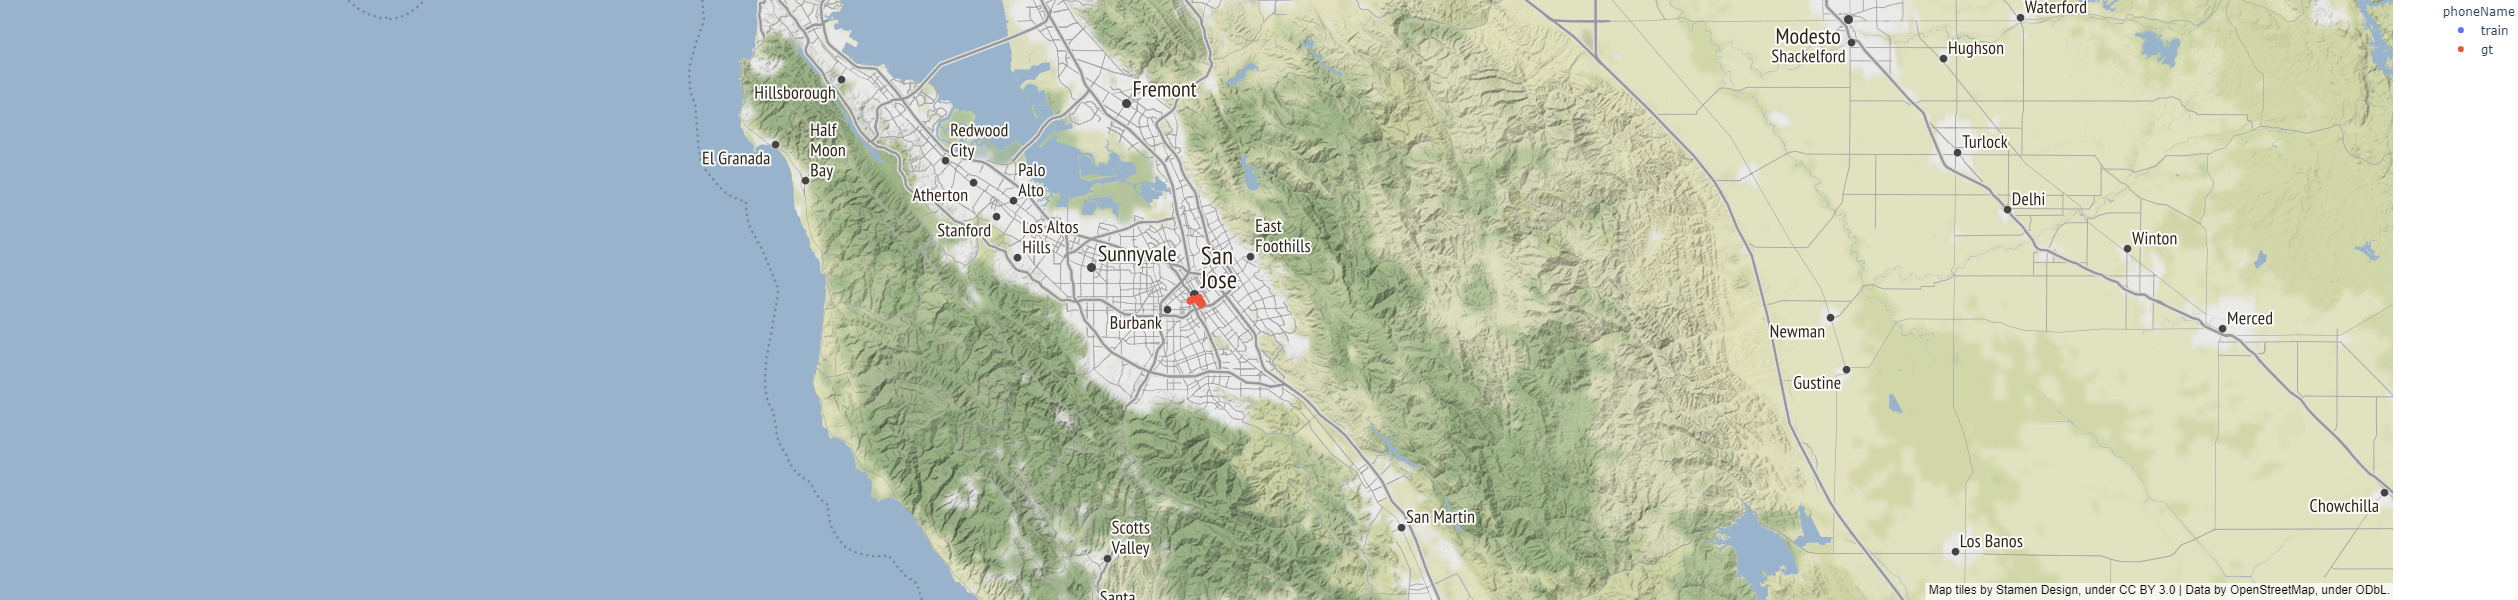

In [39]:
vis(train, '2021-04-22-US-SJC-1_Pixel4')

# 相対補正

In [15]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [16]:
def relative_correction(df, a):
    df_index = list(df.index)
    for idx in df_index:
        b = 1 - a
        
        if idx == df.index[-1]-1:
            break
        
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue

        
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx+1, 'latDeg']
        lng_hat_t1 = df.at[idx+1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx+1, 'latDeg'] = lat_new
            df.at[idx+1, 'lngDeg'] = lng_new
    
    df_index.reverse()
    for idx in df_index:
        if idx == df.index[0]:
            break
        
        if df.at[idx, 'phone'] != df.at[idx-1, 'phone']:
            continue
            
        lat_hat_t0 = df.at[idx, 'latDeg']
        lng_hat_t0 = df.at[idx, 'lngDeg']
        lat_hat_t1 = df.at[idx-1, 'latDeg']
        lng_hat_t1 = df.at[idx-1, 'lngDeg']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        # 角度を反転
        if deg < 180:
            deg += 180
        else:
            deg -= 180        
        
        res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
        if res:
            lat_rel = res['lat']
            lng_rel = res['lon']
            
            lat_new = lat_hat_t1 * a + lat_rel * b
            lng_new = lng_hat_t1 * a + lng_rel * b
            
            df.at[idx-1, 'latDeg'] = lat_new
            df.at[idx-1, 'lngDeg'] = lng_new
        
        
    return df    

In [17]:
degree = pd.read_csv('../output/prep/degree_pred_v002/train_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/train_distance_pred.csv')
dist = dist.rename(columns={'pred': 'dist_pred'}) 
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
train = train.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

train.loc[train['isSpeed0'], 'dist_pred'] = 0

In [18]:
target_df = train.copy()
target_df = relative_correction(target_df, rel_rate)
target_df = target_df[target_df['collectionName'].isin(rel_target)].copy()
train.loc[target_df.index, ['latDeg', 'lngDeg']] = target_df[['latDeg', 'lngDeg']]

target_df = train.copy()
target_df = relative_correction(target_df, rel_rate)
target_df = target_df[target_df['collectionName'].isin(rel_target)].copy()
train.loc[target_df.index, ['latDeg', 'lngDeg']] = target_df[['latDeg', 'lngDeg']]

train.to_csv(OUTPUT + '/train_ro_rel.csv', index=False)

# kalmanフィルタ

In [23]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [24]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_kf.csv', index=False)

# speed0の処理

In [25]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [26]:
train

collectionName        phoneName  millisSinceGpsEpoch     latDeg  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442  37.423549   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442  37.423564   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442  37.423573   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442  37.423578   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442  37.423579   
...                     ...              ...                  ...        ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000  37.334472   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000  37.334474   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000  37.334478   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000  37.334482   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000  37.334486   

            lngDeg  heightAboveWgs84EllipsoidM  \
0      -122.094006                      -34.06   
1      -122.094063                      -33.29   
2      -122.094098                      -30.99   
3      -122.094116                      -32.83   
4      -122.094123                      -34.49   
...            ...                         ...   
131337 -121.899596                       -8.09   
131338 -121.899591                       -7.59   
131339 -121.899585                       -8.35   
131340 -121.899578                       -8.73   
131341 -121.899571                       -7.64   

                                      phone  latDeg_prev  latDeg_next  \
0                2020-05-14-US-MTV-1_Pixel4          NaN    37.423578   
1                2020-05-14-US-MTV-1_Pixel4    37.423575    37.423573   
2                2020-05-14-US-MTV-1_Pixel4    37.423578    37.423583   
3                2020-05-14-US-MTV-1_Pixel4    37.423573    37.423579   
4                2020-05-14-US-MTV-1_Pixel4    37.423583    37.423578   
...                                     ...          ...          ...   
131337  2021-04-29-US-SJC-2_SamsungS20Ultra    37.334457    37.334472   
131338  2021-04-29-US-SJC-2_SamsungS20Ultra    37.334460    37.334491   
131339  2021-04-29-US-SJC-2_SamsungS20Ultra    37.334472    37.334495   
131340  2021-04-29-US-SJC-2_SamsungS20Ultra    37.334491    37.334485   
131341  2021-04-29-US-SJC-2_SamsungS20Ultra    37.334495          NaN   

        lngDeg_prev  lngDeg_next                           phone_prev  \
0               NaN  -122.094101                                  NaN   
1       -122.094091  -122.094111           2020-05-14-US-MTV-1_Pixel4   
2       -122.094101  -122.094121           2020-05-14-US-MTV-1_Pixel4   
3       -122.094111  -122.094114           2020-05-14-US-MTV-1_Pixel4   
4       -122.094121  -122.094126           2020-05-14-US-MTV-1_Pixel4   
...             ...          ...                                  ...   
131337  -121.899610  -121.899583  2021-04-29-US-SJC-2_SamsungS20Ultra   
131338  -121.899600  -121.899597  2021-04-29-US-SJC-2_SamsungS20Ultra   
131339  -121.899583  -121.899583  2021-04-29-US-SJC-2_SamsungS20Ultra   
131340  -121.899597  -121.899570  2021-04-29-US-SJC-2_SamsungS20Ultra   
131341  -121.899583          NaN  2021-04-29-US-SJC-2_SamsungS20Ultra   

                                 phone_next  dist_prev  dist_next   calc_deg  \
0                2020-05-14-US-MTV-1_Pixel4        NaN   0.888202   0.981589   
1                2020-05-14-US-MTV-1_Pixel4   0.888202   1.001204   0.787438   
2                2020-05-14-US-MTV-1_Pixel4   1.001204   1.370528   0.705617   
3                2020-05-14-US-MTV-1_Pixel4   1.370528   0.741296   0.645836   
4                2020-05-14-US-MTV-1_Pixel4   0.741296   1.111176   0.638460   
...                                     ...        ...        ...        ...   
131337  2021-04-29-US-SJC-2_SamsungS20Ultra   0.941490   2.011345  38.975880   
131338  2021-04-29-US-SJC-2_SamsungS20Ultra   2.011345   

In [27]:
train_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
del train['isSpeed0']
train = sp0_process(train, train_sp0_pred)
train.to_csv(OUTPUT + '/train_ro_rel_rog_kf_sp0.csv', index=False)

# phones_mean

In [28]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [29]:
train_lerp = make_lerp_data(train)
train = calc_mean_pred(train, train_lerp)
train.to_csv(OUTPUT + '/train_ro_rel_rog_kf_sp0_pm.csv', index=False)

# position_shift

In [30]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [31]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [32]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [33]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-06-23 23:08:54,404] A new study created in memory with name: no-name-2cde533d-0965-4242-81b5-13286839ac43
[I 2021-06-23 23:08:58,141] Trial 0 finished with value: 3.869069739758697 and parameters: {'a': -0.949151378206762}. Best is trial 0 with value: 3.869069739758697.
[I 2021-06-23 23:09:01,902] Trial 1 finished with value: 3.421322399032345 and parameters: {'a': 0.426230674005565}. Best is trial 1 with value: 3.421322399032345.
[I 2021-06-23 23:09:05,609] Trial 2 finished with value: 3.4254222061765613 and parameters: {'a': 0.3577565851628002}. Best is trial 1 with value: 3.421322399032345.
[I 2021-06-23 23:09:09,280] Trial 3 finished with value: 3.4193731376921814 and parameters: {'a': 0.652376267336944}. Best is trial 3 with value: 3.4193731376921814.
[I 2021-06-23 23:09:13,177] Trial 4 finished with value: 3.6119677788628883 and parameters: {'a': -0.39480361532558494}. Best is trial 3 with value: 3.4193731376921814.
[I 2021-06-23 23:09:16,860] Trial 5 finished with value:

0.5308628192693767


In [34]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rel_rog_kf_sp0_pm_ps.csv', index=False)

# trainの結果確認

In [35]:
for f in ['train_ro_rel', 'train_ro_rel_rog', 'train_ro_rel_rog_kf_sp0', 'train_ro_rel_rog_kf_sp0_pm', 'train_ro_rel_rog_kf_sp0_pm_ps']:
    print(f, get_train_score(pd.read_csv(OUTPUT + '/' + f + '.csv'), gt))

train_ro_rel 3.7412902169325624
train_ro_rel_rog 4.150800338241817
train_ro_rel_rog_kf_sp0 3.722990068474021
train_ro_rel_rog_kf_sp0_pm 3.4874933726651585
train_ro_rel_rog_kf_sp0_pm_ps 3.415837063669255


In [36]:
result = train_result(train)

In [37]:
result.err

percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               1.166213      2.324532      1.745372
2020-05-14-US-MTV-1_Pixel4XLModded       1.053804      2.189887      1.621846
2020-05-14-US-MTV-2_Pixel4               1.694070      3.080245      2.387157
2020-05-14-US-MTV-2_Pixel4XLModded       1.796528      4.586628      3.191578
2020-05-21-US-MTV-1_Pixel4               1.763779      3.154850      2.459315
2020-05-21-US-MTV-2_Pixel4               0.642368      2.257316      1.449842
2020-05-21-US-MTV-2_Pixel4XL             0.600042      2.149450      1.374746
2020-05-29-US-MTV-1_Pixel4               2.061866      3.482491      2.772178
2020-05-29-US-MTV-1_Pixel4XL             1.841507      3.090666      2.466087
2020-05-29-US-MTV-1_Pixel4XLModded       1.695646      3.191316      2.443481
2020-05-29-US-MTV-2_Pixel4               2.242499      3.459641      2.851070
2020-05-29-US-MTV-2_Pixel4XL             2.169132      3.488438      2.828785
2020-06-04-US-MTV-1_Pixel4               1.255989      2.555642      1.905815
2020-06-04-US-MTV-1_Pixel4XL             0.751114      2.228275      1.489694
2020-06-04-US-MTV-1_Pixel4XLModded       1.601073      2.739101      2.170087
2020-06-05-US-MTV-1_Pixel4               1.175279      2.388693      1.781986
2020-06-05-US-MTV-1_Pixel4XL             1.228280      2.475370      1.851825
2020-06-05-US-MTV-1_Pixel4XLModded       1.028465      2.124507      1.576486
2020-06-05-US-MTV-2_Pixel4               0.929578      2.527999      1.728789
2020-06-05-US-MTV-2_Pixel4XL             0.880828      2.437316      1.659072
2020-06-11-US-MTV-1_Pixel4               0.966274      1.900221      1.433247
2020-06-11-US-MTV-1_Pixel4XL             1.019786      1.973909      1.496847
2020-07-08-US-MTV-1_Pixel4               1.359156      2.562411      1.960783
2020-07-08-US-MTV-1_Pixel4XL             1.186384      2.278778      1.732581
2020-07-08-US-MTV-1_Pixel4XLModded       0.860646      2.474976      1.667811
2020-07-17-US-MTV-1_Mi8                  1.721805      3.438210      2.580008
2020-07-17-US-MTV-2_Mi8                  2.876783      4.235299      3.556041
2020-08-03-US-MTV-1_Mi8                  1.661337      2.785217      2.223277
2020-08-03-US-MTV-1_Pixel4               1.786777      2.959361      2.373069
2020-08-06-US-MTV-2_Mi8                  1.727415      2.911076      2.319245
2020-08-06-US-MTV-2_Pixel4               1.126326      2.102062      1.614194
2020-08-06-US-MTV-2_Pixel4XL             1.046386      2.714181      1.880284
2020-09-04-US-SF-1_Mi8                   2.053416      3.574502      2.813959
2020-09-04-US-SF-1_Pixel4                1.848724     10.909176      6.378950
2020-09-04-US-SF-1_Pixel4XL              1.287291      2.510345      1.898818
2020-09-04-US-SF-2_Mi8                   1.598414      4.720180      3.159297
2020-09-04-US-SF-2_Pixel4                1.165252      3.544681      2.354966
2020-09-04-US-SF-2_Pixel4XL              0.825935      3.930359      2.378147
2021-01-04-US-RWC-1_Pixel4               1.050236      2.599097      1.824667
2021-01-04-US-RWC-1_Pixel4Modded         1.826777      3.768371      2.797574
2021-01-04-US-RWC-1_Pixel4XL             1.878153      5.227809      3.552981
2021-01-04-US-RWC-1_Pixel5               1.202701      2.723725      1.963213
2021-01-04-US-RWC-2_Pixel4               1.747331      2.990000      2.368665
2021-01-04-US-RWC-2_Pixel4Modded         2.018233      4.496602      3.257417
2021-01-04-US-RWC-2_Pixel4XL             2.306333      6.230122      4.268227
2021-01-04-US-RWC-2_Pixel5               1.634343      3.656907      2.645625
2021-01-05-US-SVL-1_Mi8                  1.365561      3.048394      2.206977
2021-01-05-US-SVL-1_Pixel4               1.050578      3.777927      2.414253
2021-01-05-US-SVL-1_Pixel4XL             2.573874      5.731950      4.152912
2021-01-05-US-SVL-1_Pixel5               3.118649      6.81

# make_sub

In [38]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')

In [39]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [40]:
degree = pd.read_csv('../output/prep/degree_pred_v002/test_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/test_distance_pred.csv')
dist = dist.rename(columns={'pred': 'dist_pred'}) 
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')

test = test.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
test = test.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
test = test.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

test.loc[train['isSpeed0'], 'dist_pred'] = 0

KeyError: 'isSpeed0'

In [ ]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df.to_csv(OUTPUT + '/test_rog.csv', index=False)
rog_df = interpolate_remove_point(rog_df)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [ ]:
test = apply_kf_smoothing(test)

In [ ]:
test_sp0_pred = pd.read_csv('../output/prep/speed0_pred_v001/test_sp0_pred.csv')
del test['isSpeed0']
test = sp0_process(test, test_sp0_pred)

In [ ]:
target_df = test.copy()
target_df = relative_correction(target_df, rel_rate)
target_df = target_df[target_df['collectionName'].isin(rel_target)].copy()
test.loc[target_df.index, ['latDeg', 'lngDeg']] = target_df[['latDeg', 'lngDeg']]

In [ ]:
test_lerp = make_lerp_data(test)
test = calc_mean_pred(test, test_lerp)

In [ ]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']

In [ ]:
test = position_shift(test, opt_a)

In [ ]:
assert len(test) == len(sub)

In [ ]:
sub['latDeg'] = test['latDeg']
sub['lngDeg'] = test['lngDeg']
sub.to_csv(OUTPUT + f'/{nb_name}_submission.csv', index=False)